<IPython.core.display.Javascript object>


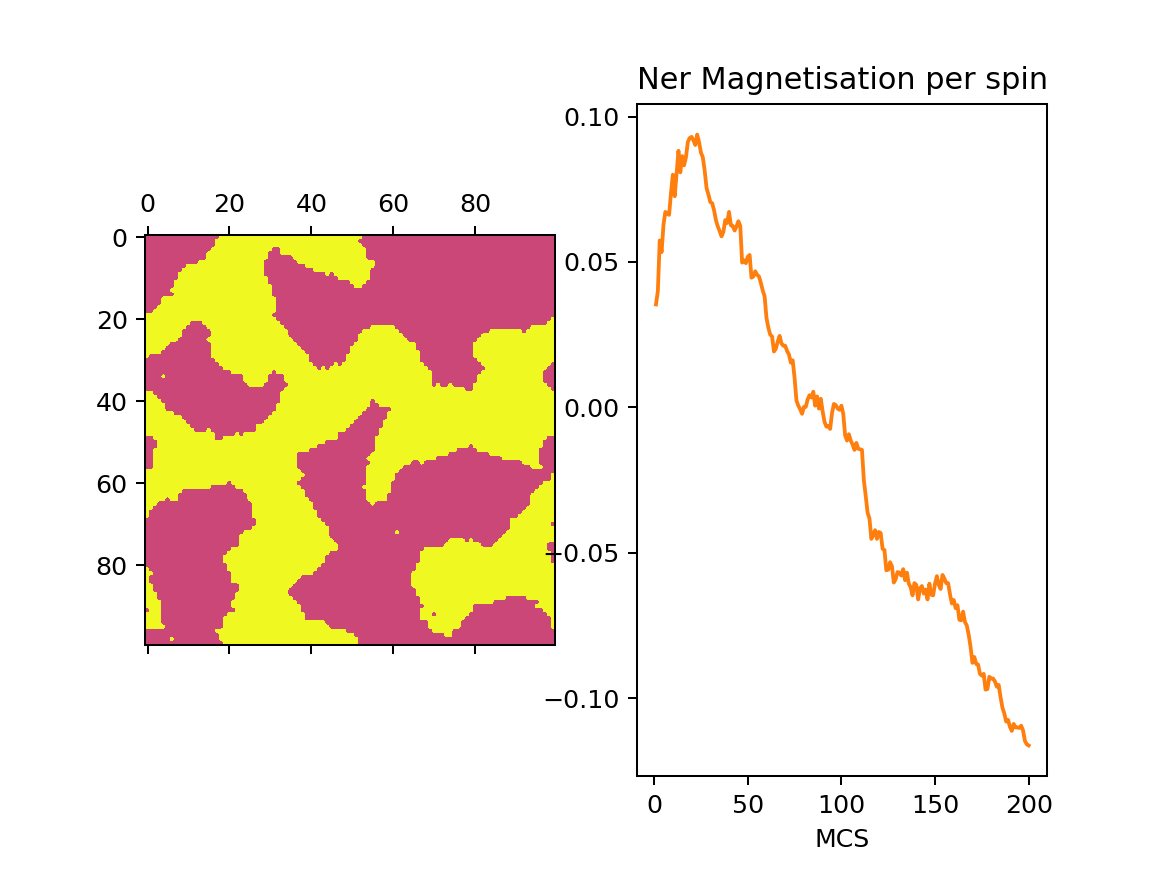

1      0.0354
2      0.04
3      0.0574
4      0.0534
5      0.0628
6      0.0672
7      0.0666
8      0.0662
9      0.0736
10      0.08
11      0.0726
12      0.0806
13      0.0882
14      0.0808
15      0.0864
16      0.0832
17      0.086
18      0.0912
19      0.0926
20      0.093
21      0.0918
22      0.0902
23      0.0938
24      0.0912
25      0.0876
26      0.086
27      0.0814
28      0.0754
29      0.0732
30      0.0706
31      0.0702
32      0.0678
33      0.0644
34      0.0622
35      0.0606
36      0.0588
37      0.0604
38      0.0644
39      0.0634
40      0.0672
41      0.0626
42      0.0624
43      0.0608
44      0.0622
45      0.064
46      0.0624
47      0.0498
48      0.0506
49      0.0496
50      0.0518
51      0.0524
52      0.0446
53      0.045
54      0.0468
55      0.0456
56      0.045
57      0.0428
58      0.0402
59      0.0382
60      0.0308
61      0.0274
62      0.025
63      0.0244
64      0.0192
65      0.0202
66      0.0226
67      0.0246
68      0.022
6

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import njit
%matplotlib notebook

def largest_primes_under(N):
    n = N - 1
    while n >= 2:
        if all(n % d for d in range(2, int(n ** 0.5 + 1))):
            return n
        n -= 1

@njit
def Neighbors(Lattice,i,j,n=1):
    ''' Returns an flat array of all neighboring sites in the n-th coordination sphere including the center'''
    N, M = Lattice.shape
    rows = np.array([(i-1) % N, i, (i+1) % N])
    cols = np.array([(j-1) % N, j, (j+1) % M])
    return Lattice[rows,:][:,cols].flatten()

@njit
def calc_dE(Lattice, x, y, z):
    N, M = Lattice.shape
    old_energy = 0
    new_energy = 0
    for i in [0,1,-1]:
        for j in [0,1,-1]:
            if i == 0 and j == 0: 
                continue
            if Lattice[x%N,y%M] == Lattice[(x+i)%N,(y+j)%M]:
                old_energy += 1
            elif z == Lattice[(x+i)%N,(y+j)%M]: 
                new_energy += 1 
    return old_energy-new_energy

N, M = 100,100
beta = 1.0/1.0  # Set beta factor in units of energy/temperature (1/beta = 2.27 is Curie temp)
orientations = 2
MCS = int(200)

a = largest_primes_under(N*M)
L = np.random.randint(1,orientations+1,size=(N,M))
ims=[]
mag=[]
mcs=[]

fig, axs = plt.subplots(nrows=1, ncols=2)
mat = axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser')
mvt = axs[1].plot(mcs,mag)
axs[1].set(title='Net Magnetisation per spin', xlabel='MCS')

for t in range(1,MCS+1):
    rand = np.random.randint(N*M)
    for i in range(0,N**2):
        index = (a*i + rand) % (N**2)
        x = index % N
        y = index // N
        n = Neighbors(L,x,y)
        if len(n)-1 == 0: 
            continue
        else: 
            z = np.random.choice(orientations)+1
        dE = calc_dE(L,x,y,z)
        if  (dE < 0): 
            L[x%N,y%N] = z      
        elif np.random.sample() < np.exp(-dE*beta): 
            L[x%N,y%N] = z
           
    ims.append((axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser'),))
    
    mcs.append(t)
    mag.append((np.sum(np.where(L==1,1,0))-np.sum(np.where(L==2,1,0)))/(N*M))
    print(mcs[t-1],"    ",mag[t-1])  # Print net magnetisation per spin

ani = animation.ArtistAnimation(fig,ims,interval=100,blit=True)
lines = axs[1].plot(mcs,mag)
fig.show()